# Recommendation Systems

This notebook uses an e-commerce example to build a recommendation system to recommend products to customers. 

## Libraries

In [317]:
# !pip install numpy==1.21.5 pandas matplotlib sklearn tensorflow

In [318]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import sklearn as sk
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

In [319]:
print(np.__version__)

1.21.5


In [320]:
print(tf.__version__)

2.7.1


## Load and Explore Data

In [321]:
tlog = pd.read_csv(r"../data/sample_tlog.csv", index_col = 0)
product = pd.read_csv(r"../data/sample_product.csv", index_col = 0)
customer = pd.read_csv(r"../data/sample_customer.csv", index_col = 0).replace({"H": "high", "L": "low", "M": "medium"})

In [322]:
product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2938 entries, 0 to 2937
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   upc_no                 2938 non-null   int64 
 1   upc_desc               2938 non-null   object
 2   category_no_level_1    2938 non-null   int64 
 3   category_desc_level_1  2938 non-null   object
 4   category_no_level_2    2938 non-null   int64 
 5   category_desc_level_2  2938 non-null   object
dtypes: int64(3), object(3)
memory usage: 160.7+ KB


In [323]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            1243 non-null   int64  
 1   convenience_dim_seg    1243 non-null   object 
 2   quality_dim_seg        1243 non-null   object 
 3   health_dim_seg         1243 non-null   object 
 4   price_dim_seg          1243 non-null   object 
 5   convenience_dim_score  1243 non-null   float64
 6   quality_dim_score      1243 non-null   float64
 7   health_dim_score       1243 non-null   float64
 8   price_dim_score        1243 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 97.1+ KB


In [324]:
tlog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595306 entries, 0 to 595305
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   transaction_id       595306 non-null  object 
 1   customer_id          595306 non-null  int64  
 2   upc_no               595306 non-null  int64  
 3   category_no_level_1  595306 non-null  int64  
 4   trans_dt             595306 non-null  int64  
 5   week_no              595306 non-null  int64  
 6   store_id             595306 non-null  int64  
 7   region_cd            595306 non-null  int64  
 8   purchase_unit        595306 non-null  int64  
 9   sales_amt            595306 non-null  float64
 10  disc_amt             595306 non-null  float64
 11  purchase_price       595283 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 59.0+ MB


In [325]:
# encode customer_id and upc_no to start from 0
customer = customer.assign(customer_id_code = customer.customer_id.astype("category").cat.codes)
product = product.assign(upc_no_code = product.upc_no.astype("category").cat.codes)

tlog = tlog.merge(customer[["customer_id", "customer_id_code"]], on = "customer_id", how = "left")\
.merge(product[["upc_no", "upc_no_code"]], on = "upc_no", how = "left")

In [326]:
sales = tlog[["customer_id_code", "upc_no_code", "purchase_unit"]]\
.rename({"customer_id_code": "customer_id", "upc_no_code": "upc_no"}, axis = 1)\
.groupby(["customer_id", "upc_no"])\
.agg({"purchase_unit": "sum"}).reset_index()
sales.head()

,customer_id,upc_no,purchase_unit
0,0,363,1
1,0,1358,1
2,0,1361,2
3,0,1363,1
4,1,6,18


In [327]:
print("There are {:.0f} products, {:.0f} customers in the dataset.".format(
    len(tlog.upc_no.unique()),
    len(tlog.customer_id.unique())))

There are 2938 products, 1243 customers in the dataset.


### Customers

array([[<AxesSubplot:title={'center':'# of units purchased per customer'}>]],
      dtype=object)

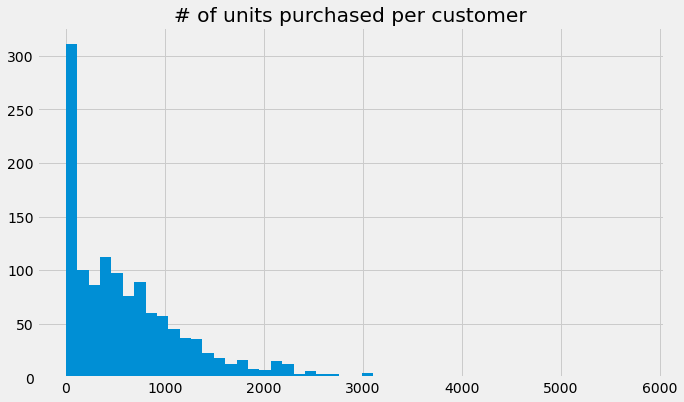

In [328]:
sales.groupby("customer_id")\
.agg(purchase_unit_sum = ("purchase_unit", "sum"))\
.reset_index()\
.drop("customer_id", axis = 1)\
.rename({"purchase_unit_sum": "# of units purchased per customer"}, axis = 1)\
.hist(figsize = (10, 6), bins = 50)

<AxesSubplot:title={'center':'Price Dimension'}>

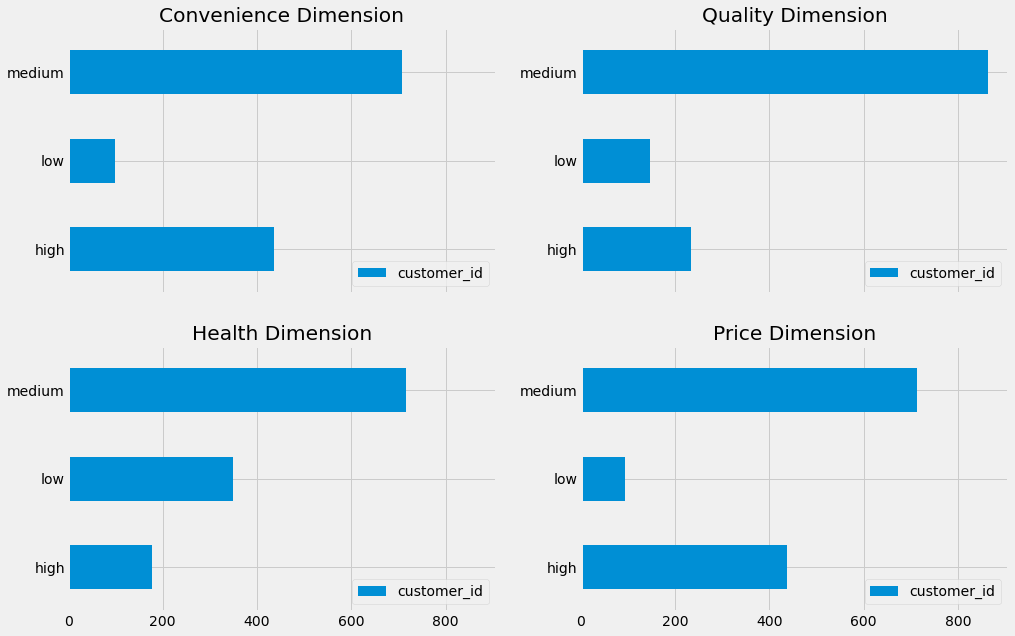

In [329]:
fig, ax = plt.subplots(2,2, sharex = True)
figsize = (15, 10)

customer.groupby(["convenience_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[0][0], title = "Convenience Dimension", xlabel = "")

customer.groupby(["quality_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[0][1], title = "Quality Dimension", xlabel = "")

customer.groupby(["health_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[1][0], title = "Health Dimension", xlabel = "")

customer.groupby(["price_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[1][1], title = "Price Dimension", xlabel = "")

### Products

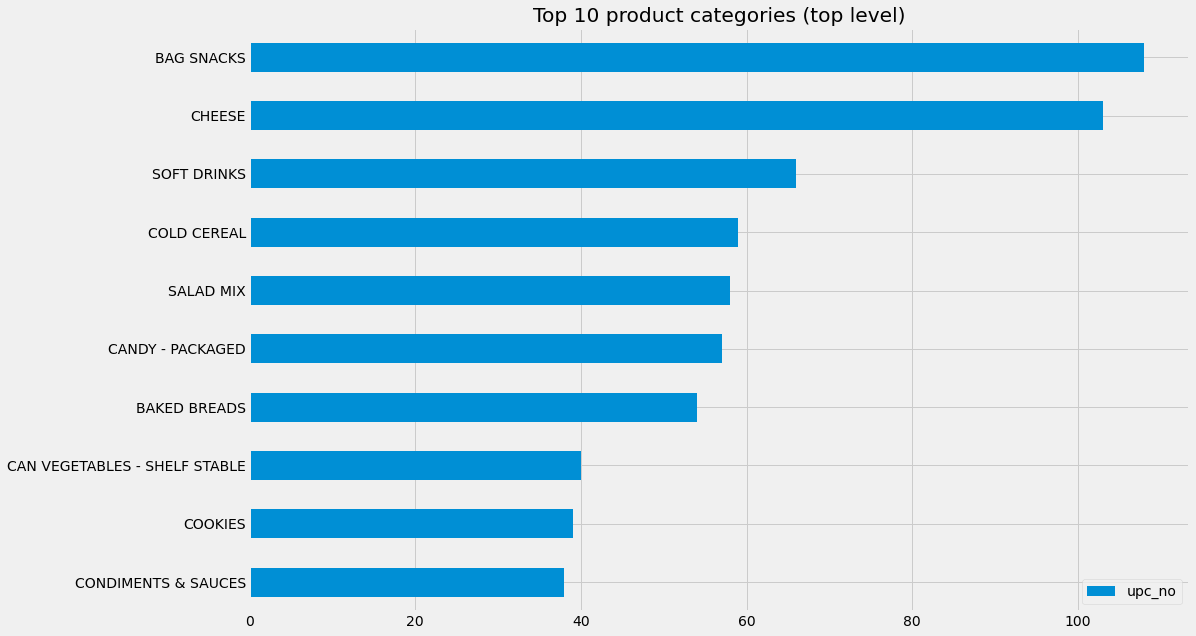

In [330]:
top = 10
product.groupby(["category_desc_level_2"])\
.agg({"upc_no": "count"})\
.reset_index()\
.sort_values(by = "upc_no", ascending = False)[:top]\
.plot.barh(x = "category_desc_level_2", y = "upc_no", figsize = figsize, title = "Top {:.0f} product categories (top level)".format(top), xlabel = "")
plt.gca().invert_yaxis()

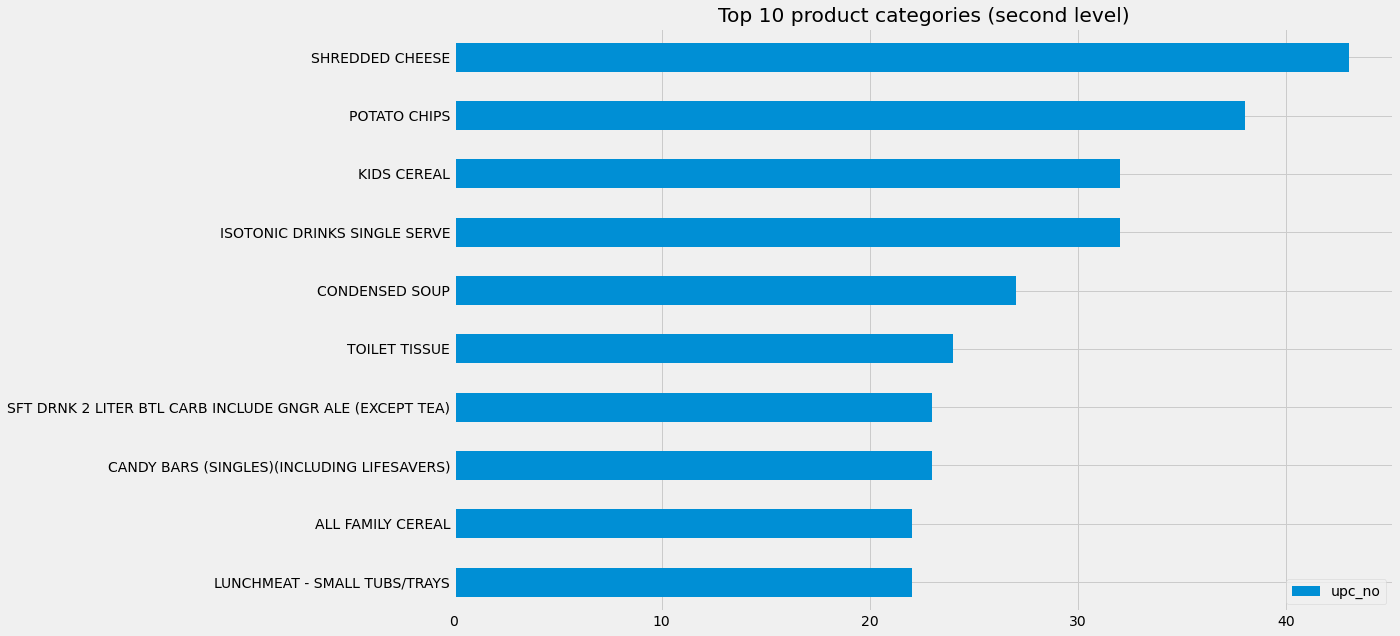

In [331]:
product.groupby(["category_desc_level_1"])\
.agg({"upc_no": "count"})\
.reset_index()\
.sort_values(by = "upc_no", ascending = False)[:top]\
.plot.barh(x = "category_desc_level_1", y = "upc_no", figsize = figsize, title = "Top {:.0f} product categories (second level)".format(top), xlabel = "")
plt.gca().invert_yaxis()

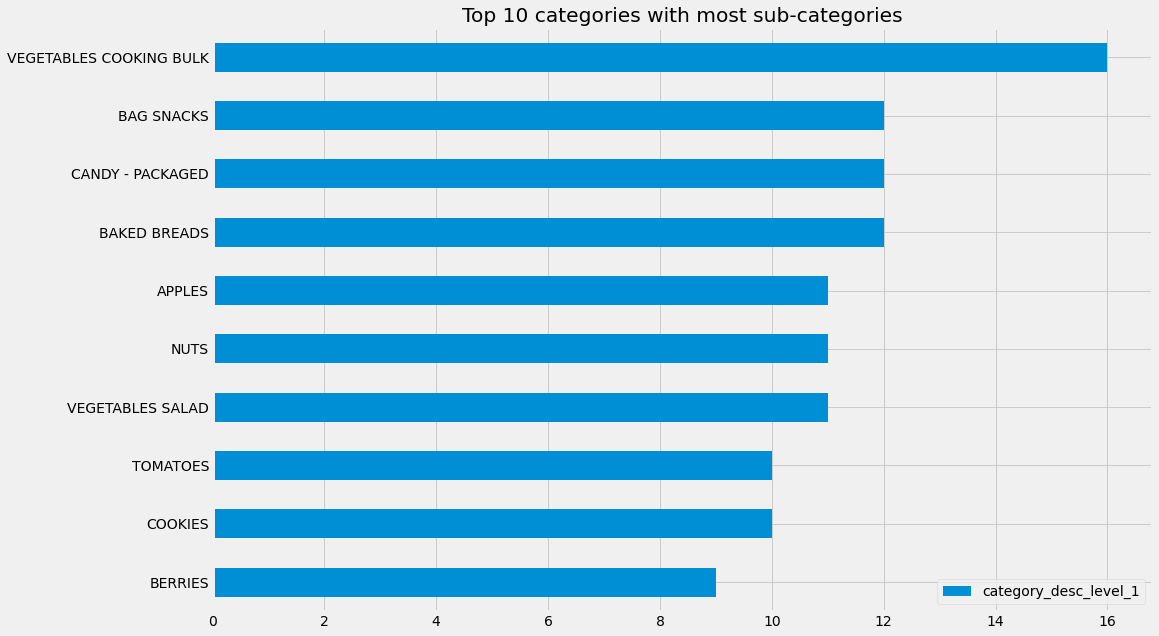

In [440]:
product.groupby(["category_desc_level_2"])\
.agg({"category_desc_level_1": lambda x: x.nunique()})\
.reset_index()\
.sort_values(by = "category_desc_level_1", ascending = False)[:top]\
.plot.barh(x = "category_desc_level_2", y = "category_desc_level_1", 
           title = "Top %d categories with most sub-categories" % top,
           figsize = figsize,
           xlabel = "")
plt.gca().invert_yaxis()

<AxesSubplot:title={'center':'# of units purchased for each product'}>

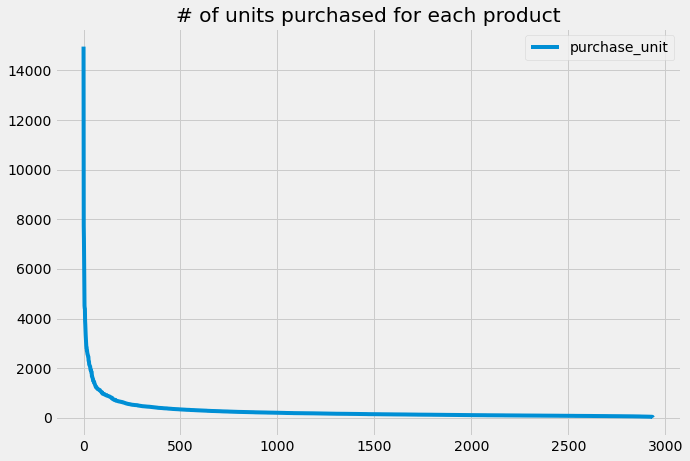

In [332]:
sales.groupby("upc_no").agg({"purchase_unit": "sum"})\
.sort_values("purchase_unit", ascending = False).reset_index(drop = True)\
.plot(figsize = (10,7), title = "# of units purchased for each product")

## Recommendation Algorithms

In [333]:
sales = sales.assign(purchase = lambda x: x["purchase_unit"] > 0)\
.replace({True: 1, False: 0})
sales.head(2)

,customer_id,upc_no,purchase_unit,purchase
0,0,363,1,1
1,0,1358,1,1


### Matrix-Based Implementation with Tensorflow

- [reference](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=8k9CSOH5o4tX)

#### Sparse representation of transaction matrix in tensorflow and loss calculation

In `sales` we have:

customer\_id | upc\_no | purchase_unit
--:|--:|--:
0|1|	1
0|2|	1
0|3|	2
0|4|	1
1|5|	18

We can transform to a transaction matrix where each row is a customer and each column is a product:
$$
A =
\begin{bmatrix}
1 & 1 & 2 & 1 & 0 \\
0 & 0 & 0 & 0 & 18
\end{bmatrix}
$$

And the Sparse Representation of the Transaction Matrix is:
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [0, 2], [0, 3], [1,4]],
  values=[1, 1, 2, 1, 18],
  dense_shape=[2, 5])
```

In [334]:
def build_transaction_sparse_tensor(df):
    indices = df[["customer_id", "upc_no"]].values
    values = df["purchase"].values
    return tf.SparseTensor(
        indices = indices,
        values = values,
        dense_shape = [len(customer), len(product)]
    )

Now imagine we have two embedding matrices, $U$ for customer embedding, and $V$ for product embedding, and want to be able to represent the transaction matrix $A$ by their product. How we achieve that is by minimizing the loss function calculating the difference between the transaction matrix $A$ and the dot product of two embedding matrices:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$

In [335]:
# computing full matrix UV, need to be updated if number of customers too large
def sparse_mean_squared_error(sparse_transactions, customer_embeddings, product_embeddings):
    predictions = tf.gather_nd(
        tf.matmul(customer_embeddings, product_embeddings, transpose_b = True), 
        sparse_transactions.indices    
    )
    loss = tf.losses.mean_squared_error(sparse_transactions.values, predictions)
    return loss

In [336]:
class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics = None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None
        
    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations = 100, learning_rate = 1.0, plot_result = True,
             optimizer = tf.train.GradientDescentOptimizer):
        
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer()
            )
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()
                    
            with self._session.as_default():
                local_init_op.run()
                iterations = []
                metrics = self._metrics or ({},)
                metrics_vals = [collections.defaultdict(dict) for _ in self._metrics]
                
            
                for i in range(num_iterations + 1):
                    _, results = self._session.run((train_op, metrics))
                    if (i % 10 == 0) or i == num_iterations:
                        print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]), 
                        end = "")

                        iterations.append(i)

                        for metric_val, result in zip(metrics_vals, results):
                            for k, v in result.items():
                                if k not in metric_val:
                                    metric_val[k] = [v]
                                else:
                                    metric_val[k].append(v)

                for k, v in self._embedding_vars.items():
                    self._embeddings[k] = v.eval()

                if plot_result:
                    num_subplots = len(metrics) + 1
                    fig = plt.figure()
                    fig.set_size_inches(num_subplots * 10, 8)
                    for i, metric_vals in enumerate(metrics_vals):
                        ax = fig.add_subplot(1, num_subplots, i + 1)
                        for k, v in metric_vals.items():
                            ax.plot(iterations, v, label = k)
                        ax.set_xlim([1, num_iterations])
                        ax.legend()

            return results

In [337]:
def build_model(mat, embedding_dim = 3, init_stddev = 1.):
    train, test = sk.model_selection.train_test_split(sales, test_size=0.2)
    A_train = build_transaction_sparse_tensor(train)
    A_test = build_transaction_sparse_tensor(test)
    U = tf.Variable(
        tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev = init_stddev
        )
    )
    V = tf.Variable(
        tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev = init_stddev
        )
    )
    train_loss = sparse_mean_squared_error(A_train, U, V)
    test_loss = sparse_mean_squared_error(A_test, U, V)
    metrics = {
        "train_error": train_loss,
        "test_error": test_loss
    }
    embeddings = {
        "customer_id": U,
        "upc_no": V
    }
    return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.016005, test_error=0.048100

[{'train_error': 0.016005471, 'test_error': 0.048099853}]

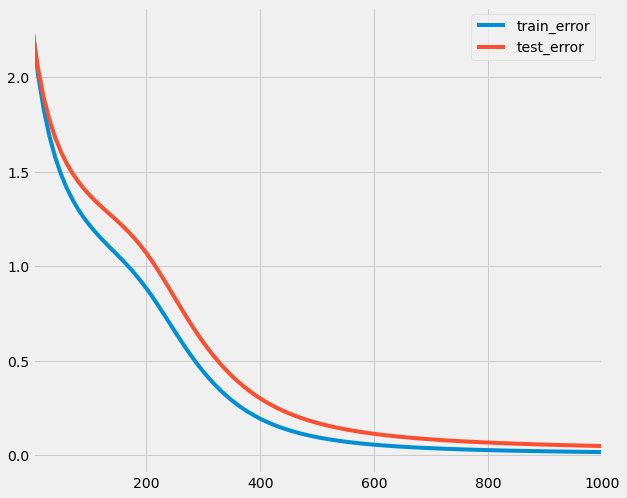

In [338]:
model = build_model(sales, embedding_dim = 20, init_stddev = 0.5)
model.train(num_iterations = 1000, learning_rate = 10.)

#### Compute score of each product $V_j$

In [339]:
DOT = 'dot'
COSINE = 'cosine'

def compute_score(query_embedding, item_embeddings, measure = COSINE):
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        u = u / np.linalg.norm(u)
        V = V / np.linalg.norm(V, axis = 1, keepdims = True)
    return u.dot(V.T)

In [807]:
# for each customer, recommend products
def customer_recommendation(model, customer_id, measure = COSINE, k = 10, exclude_bought = False):
    scores = compute_score(
        model.embeddings["customer_id"][customer_id], 
        model.embeddings["upc_no"], 
        measure
    )
    score_key = measure + " score"
    df = pd.DataFrame({
        score_key: list(scores),
        "product id": product["upc_no_code"],
        "product name": product["upc_desc"],
        "category": product["category_desc_level_1"],
        "subcategory": product["category_desc_level_2"]
    })
    if exclude_bought:
        bought_items = sales.query("customer_id == @customer_id")["upc_no"].unique()
        df = df[df["product id"].apply(lambda x: x not in bought_items)]
    print("\n".join(df.sort_values([score_key], ascending = False).head(k)["product name"].values))
    display.display(df.sort_values([score_key], ascending = False).head(k))

In [808]:
customer_recommendation(model, 8)

BF TP RND LNDN BRL BLS CH
KRFT GRTD PARMESAN CHEESE
KTTL BACKYARD BBQ CHIPS
BEYE SWEET KERNEL CORN
OSCM DELI SHV OV RST TRKY
HNTS TOMATO SAUCE
OSCM DELI SHAVD HONEY HAM
HF BLK FRST HM SLCD TB TN
REESES PBTR CUP KING SIZE
STO BABY SPINACH


,cosine score,product id,product name,category,subcategory
2132,0.780589,2791,BF TP RND LNDN BRL BLS CH,CHOICE BEEF,BEEF:ROUND
572,0.753194,1442,KRFT GRTD PARMESAN CHEESE,GRATED CHEESE,DRY CHEESE
402,0.747640,2662,KTTL BACKYARD BBQ CHIPS,POTATO CHIPS,NF SNACK
1090,0.726142,1280,BEYE SWEET KERNEL CORN,FZ BAG VEGETABLES - PLAIN,FROZEN VEGETABLE & VEG DISH
43,0.719045,2145,OSCM DELI SHV OV RST TRKY,LUNCHMEAT - SMALL TUBS/TRAYS,LUNCHMEAT
22,0.717611,1530,HNTS TOMATO SAUCE,TOMATO SAUCE,TOMATO PRODUCTS-SHELF STABLE
40,0.712237,2147,OSCM DELI SHAVD HONEY HAM,LUNCHMEAT - SMALL TUBS/TRAYS,LUNCHMEAT
42,0.705278,2117,HF BLK FRST HM SLCD TB TN,LUNCHMEAT - SMALL TUBS/TRAYS,LUNCHMEAT
559,0.700907,1741,REESES PBTR CUP KING SIZE,CANDY BARS (SINGLES)(INCLUDING LIFESAVERS),CANDY - CHECKLANE
48,0.694865,1066,STO BABY SPINACH,SALAD SPINACH ORGANIC,SALAD MIX


In [342]:
# for each product find similar products
def product_neighbors(model, desc, measure = COSINE, k = 10):
    ids = product[product["upc_desc"].str.contains(desc)].index.values
    descs = product.iloc[ids]["upc_desc"].values
    
    if len(descs) == 0:
        raise ValueError("Found no products for %s" % desc)
    print("Nearest neighbors of : %s." % descs[0])
    
    if len(descs) > 1:
        print("Found more than 1 matching product. Other candidates: {}".format(", ".join(descs[1:])))

    prod_id = ids[0]
    scores = compute_score(
        model.embeddings["upc_no"][prod_id], model.embeddings["upc_no"], measure
    )
    score_key = measure + " score"
    df = pd.DataFrame({
        score_key : list(scores),
        "product name": product["upc_desc"],
        "category": product["category_desc_level_1"],
        "subcategory": product["category_desc_level_2"]
    })
    display.display(df.sort_values([score_key], ascending = False).head(k))

In [343]:
p = "coffee"
product_neighbors(model, p.upper())

Nearest neighbors of : HOST CINN COFFEE CAKE 8CT.
Found more than 1 matching product. Other candidates: MXHS ORIGINAL COFFEE


,cosine score,product name,category,subcategory
756,1.000000,HOST CINN COFFEE CAKE 8CT,SNACK CAKE - MULTI PACK,BAKED SWEET GOODS
1023,0.737832,KRO HAVARTI SLICES,NATURAL CHEESE SLICES,CHEESE
582,0.702602,LACHY SLCD WATER CHESTNUT,ASIAN VEGETABLES,ASIAN FOODS
2533,0.687678,CRABCAKE FROZEN EA SC,CRAB - OTHER,SEAFOOD - CRAB
1492,0.650661,NBSC CHIPS AHOY CHW REESE,TRAY PACK/CHOC CHIP COOKIES,COOKIES
2637,0.649567,COKE ZERO 6PK,SFT DRNK MLT-PK BTL CARB (EXCPT TEA/GNGR ALE&M...,SOFT DRINKS
166,0.645851,KRO UNBLEACHED FLOUR,FLOUR: MISC/SPECIALTY/BLEND ETC.,FLOUR & MEALS
204,0.637249,KRO CHS GAR HMS CRTON,CROUTONS,CROUTONS/BREAD STICK&SALAD TOP
1337,0.620570,DANN OIKOS TZ MX BRY YGRT,GREEK SS YOGURT,YOGURT
2702,0.606251,STO GRAPES GRN ORGNC RPC,GRAPES WHITE ORGANIC,GRAPES


In [344]:
product_neighbors(model, p.upper(), measure = DOT)

Nearest neighbors of : HOST CINN COFFEE CAKE 8CT.
Found more than 1 matching product. Other candidates: MXHS ORIGINAL COFFEE


,dot score,product name,category,subcategory
756,5.206623,HOST CINN COFFEE CAKE 8CT,SNACK CAKE - MULTI PACK,BAKED SWEET GOODS
2917,3.874637,FRITO LAY FUN MIX 28CT,MULT PK BAG SNACKS,BAG SNACKS
1023,3.653004,KRO HAVARTI SLICES,NATURAL CHEESE SLICES,CHEESE
268,3.568580,KRO GREAT NORTHERN BEANS,VARIETY BEANS - KIDNEY/PINTO/ETC,CAN BEANS
2892,3.434771,APPLES RED DEL EURO SML,APPLES RED DELICIOUS (BULK&BAG),APPLES
2533,3.379177,CRABCAKE FROZEN EA SC,CRAB - OTHER,SEAFOOD - CRAB
990,3.237551,RDBR CLSC FOUR CHEESE PZA,PIZZA/TRADITIONAL,FROZEN PIZZA
2602,3.234453,SHRCKDTON 26/30 FZ RW SC,SHRIMP - COOKED,SEAFOOD - SHRIMP
2285,3.215128,INTD CRML MCCHTO CREAMER,REFRIG COFF CREAMER SPECIALTY FLAVORS,REFRIGERATED COFFEE CREAMERS
1337,3.119045,DANN OIKOS TZ MX BRY YGRT,GREEK SS YOGURT,YOGURT


#### Visualize product embeddings

In [565]:
from sklearn.manifold import TSNE

def tsne_product_embedding(model, product):
    tsne = TSNE(
        n_components = 2,
        perplexity = 50, 
        metric = "cosine",
        early_exaggeration = 10,
        init = "pca",
        verbose = True, 
        n_iter = 500
    )
    V_proj = tsne.fit_transform(model.embeddings["upc_no"])
    product.loc[:, "x"] = V_proj[:, 0]
    product.loc[:, "y"] = V_proj[:, 1]
    return product

product = tsne_product_embedding(model, product)

/Users/yuelong/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2938 samples in 0.000s...
[t-SNE] Computed neighbors for 2938 samples in 0.230s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2938
[t-SNE] Computed conditional probabilities for sample 2000 / 2938
[t-SNE] Computed conditional probabilities for sample 2938 / 2938
[t-SNE] Mean sigma: 0.223713
[t-SNE] KL divergence after 100 iterations with early exaggeration: 63.063858
[t-SNE] KL divergence after 500 iterations: 3.099401


Let's visualize products by their categories with TSNE:

Very distinct products: 
**Handbags, First Aid, Energy Drinks, Baby Happy Birthday Card, Home and Office, Cake Decorations**

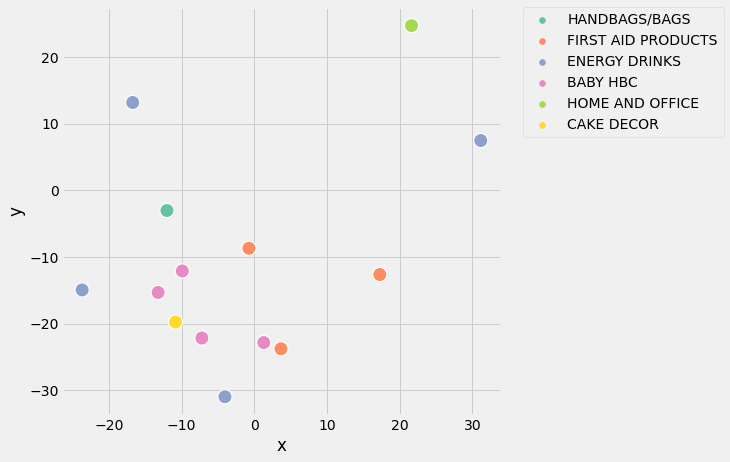

In [761]:
import seaborn as sns

cat1 = ['HOME AND OFFICE', 'HANDBAGS/BAGS', 'FIRST AID PRODUCTS', 'CAKE DECOR','BABY HBC', 'ENERGY DRINKS']
d1 = product[product["category_desc_level_2"].apply(lambda x: x in cat1)].rename({"category_desc_level_2": "category"}, axis = 1)

plt.figure(figsize = (7, 7))
sns.scatterplot(data = d1, x = "x", y = "y", hue = "category", palette = "Set2", s = 200)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Fruits: **Apples, Bananas, Citrus, Berries, Melons**

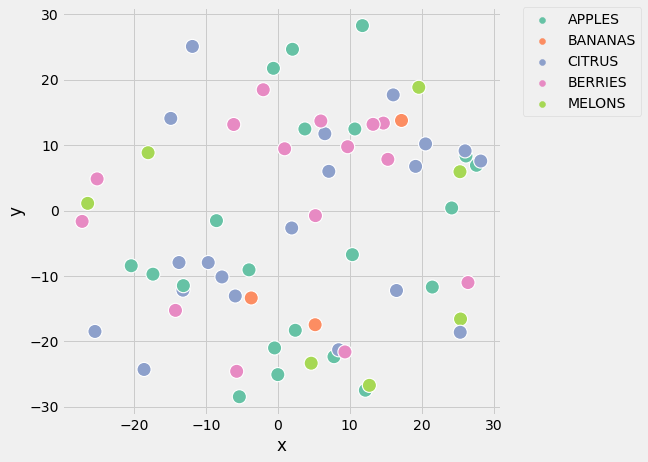

In [762]:
cat2 = ["BERRIES", "CITRUS", "APPLES", "BANANAS", "MELONS"]
d2 = product[product["category_desc_level_2"].apply(lambda x: x in cat2)].rename({"category_desc_level_2": "category"}, axis = 1)

plt.figure(figsize = (7, 7))
sns.scatterplot(data = d2, x = "x", y = "y", hue = "category", palette = "Set2", s = 200)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

By Cooking needs: **Herbs/Garlic, Frozen Vegetable and Veg Dish**

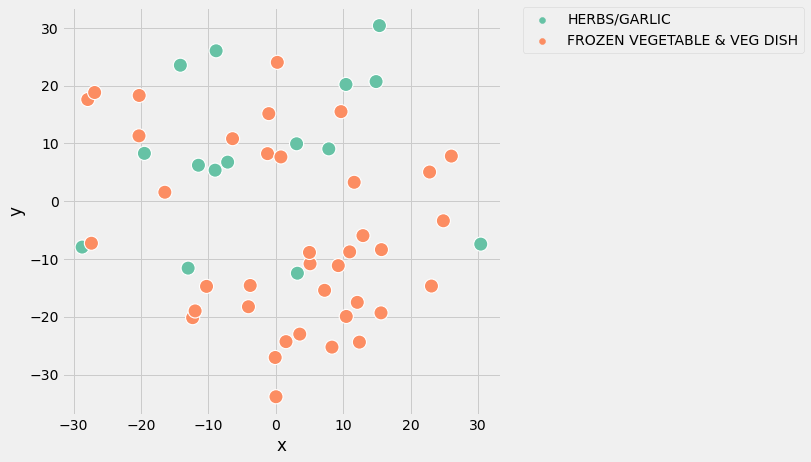

In [763]:
cat3 = ['HERBS/GARLIC', 'FROZEN VEGETABLE & VEG DISH']
d3 = product[product["category_desc_level_2"].apply(lambda x: x in cat3)].rename({"category_desc_level_2": "category"}, axis = 1)

plt.figure(figsize = (7, 7))
sns.scatterplot(data = d3, x = "x", y = "y", hue = "category", palette = "Set2", s = 200)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Save Pickles

In [789]:
from datetime import datetime
import pickle
model_timestamp = datetime.strftime(datetime.now(), "%y_%m_%d_%H_%M_%S")
export = dict()
export["data"] = {"product": product, "customer": customer, "sales": sales}
export["embeddings"] = model.embeddings
pickle.dump(export, open("../model/model_" + model_timestamp + ".pkl", "wb"))